In [1]:
import torch
import xarray
import torch.nn as nn
from glob import glob
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms

learning_rate = 1e-4
epochs = 50
batch_size = 64
data_cubes_dir = "./Data/Images/Data Cubes"
train_dir = f"{data_cubes_dir}/Train"
val_dir = f"{data_cubes_dir}/Val"
test_dir = f"{data_cubes_dir}/Test"
train_cubes_paths = glob(f"{train_dir}/*.zarr")
val_cubes_paths = glob(f"{val_dir}/*.zarr")
test_cubes_paths = glob(f"{test_dir}/*.zarr")

class AtlanticForestDataset(Dataset):
  def __init__(self, zarr_paths, transform=None):
    self.zarr_paths = zarr_paths
    self.transform = transform

  def __len__(self):
    return len(self.zarr_paths)

  def __getitem__(self, idx):
    zarr_path = self.zarr_paths[idx]
    data_cube = xarray.open_zarr(zarr_path, consolidated=False)['data_cube']
    tensor = torch.from_numpy(data_cube.values).float()
    tensor = torch.nan_to_num(tensor)
    if self.transform:
      tensor = torch.transpose(tensor, 0, 1)
      tensor = self.transform(tensor)
      tensor = torch.transpose(tensor, 0, 1)
    return tensor

train_dataset = AtlanticForestDataset(train_cubes_paths)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Below is the code to compute the mean and standard deviation for the train dataset
# We provide as well the variables already computed
mean = torch.tensor([881.1200, 996.9095, 839.9584, 3211.0962, 1839.4138, 5219.2334, 2899.2646])
std = torch.tensor([1692.1893, 1562.1083, 1555.0720, 1280.2616, 1096.6338, 2067.6047, 1164.6179])
# mean = 0.
# std = 0.
# samples = 0

# for data in train_dataloader:
#   batch_samples = data.size(0)
#   data = data.view(batch_samples, data.size(1), -1)
#   mean += data.mean(2).sum(0)
#   std += data.std(2).sum(0)
#   samples += batch_samples

# mean /= samples
# std /= samples

transform = transforms.Compose([
  transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

train_dataset = AtlanticForestDataset(train_cubes_paths, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = AtlanticForestDataset(val_cubes_paths, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [2]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv3d(
        in_channels=7, 
        out_channels=5, 
        kernel_size=(3, 3, 3),
        stride=(2, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(5),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.Conv3d(
        in_channels=5, 
        out_channels=5, 
        kernel_size=(5, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(5),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.Conv3d(
        in_channels=5, 
        out_channels=3, 
        kernel_size=(5, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(3),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.Conv3d(
        in_channels=3, 
        out_channels=1, 
        kernel_size=(3, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(1)
    )
    self.decoder = nn.Sequential(
      nn.ConvTranspose3d(
        in_channels=1, 
        out_channels=3, 
        kernel_size=(3, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(3),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.ConvTranspose3d(
        in_channels=3, 
        out_channels=5, 
        kernel_size=(5, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(5),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.ConvTranspose3d(
        in_channels=5, 
        out_channels=5, 
        kernel_size=(5, 3, 3),
        stride=(1, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(5),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.ConvTranspose3d(
        in_channels=5, 
        out_channels=7, 
        kernel_size=(3, 3, 3),
        stride=(2, 1, 1),
        padding=(0, 1, 1)),
      nn.BatchNorm3d(7)
    )  

  def encode(self, x):
    return self.encoder(x)
  
  def decode(self, x):
    return self.decoder(x)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

model = AutoEncoder()
optimzier = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = [], []
for epoch in range(epochs):
  start = datetime.now()
  model.train()
  train_loss = 0.0
  for imgs in train_dataloader:
    imgs = imgs.to(device)
    optimzier.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, imgs)
    loss.backward()
    optimzier.step()
    train_loss += loss.item()
  train_loss /= len(train_dataloader)
  train_losses.append(train_loss)

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for imgs in val_dataloader:
      imgs = imgs.to(device)
      outputs = model(imgs)
      loss = criterion(outputs, imgs)
      val_loss += loss.item()
  val_loss /= len(val_dataloader)
  val_losses.append(val_loss)
  end = datetime.now()

  print(f"[INFO] Epoch {epoch+1}")
  print(f"             Time elapsed: {end - start} Train loss={train_loss:.4f} | Validation loss={val_loss:.4f}")

  if (epoch + 1) % 10 == 0:
    model_path = f"./Model/AutoEncoder {epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)

# 292m 37.7s

[INFO] Epoch 1
             Time elapsed: 0:08:14.780822 Train loss=1.9518 | Validation loss=1.2313
[INFO] Epoch 2
             Time elapsed: 0:08:57.411245 Train loss=1.6487 | Validation loss=1.2634
[INFO] Epoch 3
             Time elapsed: 0:09:15.587892 Train loss=1.4462 | Validation loss=1.1418
[INFO] Epoch 4
             Time elapsed: 0:09:08.228779 Train loss=1.2850 | Validation loss=1.0400
[INFO] Epoch 5
             Time elapsed: 0:09:00.053919 Train loss=1.1787 | Validation loss=0.9962
[INFO] Epoch 6
             Time elapsed: 0:08:51.221554 Train loss=1.1106 | Validation loss=0.9812
[INFO] Epoch 7
             Time elapsed: 0:10:33.189713 Train loss=1.0645 | Validation loss=0.9666
[INFO] Epoch 8
             Time elapsed: 0:12:49.953485 Train loss=1.0140 | Validation loss=0.9387
[INFO] Epoch 9
             Time elapsed: 0:11:04.948950 Train loss=0.9626 | Validation loss=0.9354
[INFO] Epoch 10
             Time elapsed: 0:10:42.199025 Train loss=0.9259 | Validation loss=0.9167

KeyboardInterrupt: 

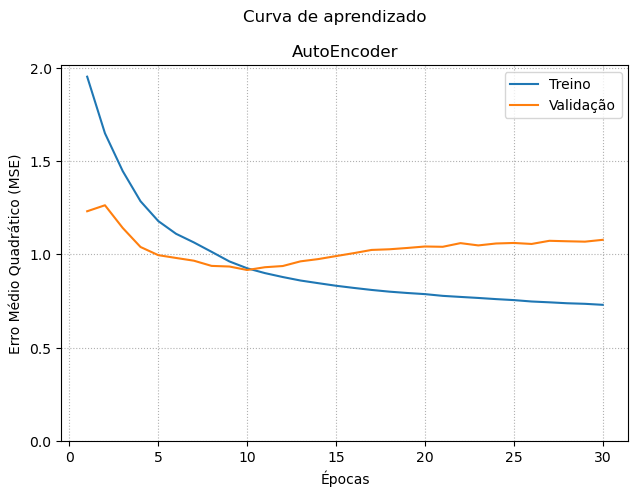

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Below are the loss' values from the uploaded model
train_losses = [np.nan, 1.9518, 1.6487, 1.4462, 1.2850, 1.1787, 1.1106, 1.0645, 1.0140, 0.9626, 0.9259, 0.9001, 0.8791, 0.8604, 0.8462, 0.8324, 0.8208, 0.8100, 0.8008, 0.7937, 0.7876, 0.7783, 0.7726, 0.7671, 0.7609, 0.7556, 0.7481, 0.7437, 0.7387, 0.7357, 0.7303]
val_losses = [np.nan, 1.2313, 1.2634, 1.1418, 1.0400, 0.9962, 0.9812, 0.9666, 0.9387, 0.9354, 0.9167, 0.9316, 0.9380, 0.9631, 0.9752, 0.9913, 1.0071, 1.0242, 1.0277, 1.0347, 1.0426, 1.0410, 1.0606, 1.0484, 1.0587, 1.0615, 1.0562, 1.0731, 1.0706, 1.0685, 1.0783]

plt.suptitle("Curva de aprendizado")
plt.title("AutoEncoder")
plt.tight_layout()

plt.plot([x for x in range(len(train_losses))], train_losses, label="Treino")
plt.plot([x for x in range(len(val_losses))], val_losses, label="Validação")
plt.ylabel("Erro Médio Quadrático (MSE)")
plt.xlabel("Épocas")
plt.grid(ls=":")
plt.yticks([tick / 10 for tick in range(0, 21, 5)])
plt.legend()
plt.show()

In [4]:
# ATTENTION! Model beign loaded. If a new model was trained and not saved, it'll be lost!
test_dataset = AtlanticForestDataset(test_cubes_paths, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model_path = "./Model/AutoEncoder 10.pth"
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()

test_loss = 0.0
with torch.no_grad():
  for imgs in test_dataloader:
    imgs = imgs.to(device)
    outputs = model(imgs)
    loss = criterion(outputs, imgs)
    test_loss += loss.item()
test_loss /= len(test_dataloader)
print(f"Test loss={test_loss:.4f}")

Test loss=0.9342
